In [124]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter, NullFormatter
import matplotlib.colors as mcolors
plt.rcParams['figure.dpi'] = 1000
plt.rcParams['font.size'] = 4
plt.rcParams['font.family'] = "Cambria"

In [4]:
# ~~~ USER VALUES HERE! ~~~ #
coverages = [0,2,4,8,16,32]
acceptable_rpms = [20, 40, 80, 160, 320, 640]
velocities = [0.05, 0.1, 0.2, 0.4, 0.8, 1.6]
radius = 23.87

In [5]:
# Read in data
paths = ["Raw_Friction_Data/" + str(coverage) + "_pct.csv" for coverage in coverages]
all_raw_data = [pd.read_csv(filepath_or_buffer=path,skiprows=2,low_memory=False) for path in paths]

In [6]:
# # Plot the raw data
# fig,ax = plt.subplots()
# for raw_data,coverage in zip(all_raw_data,coverages):
#     ax.plot(raw_data["DAQ.COF ()"],linewidth=0.2,label=coverage)
# ax.legend()
# ax.set_ylim([0,0.05])
# ax.set_xlabel("Time")
# ax.set_ylabel("COF")
# fig.set_size_inches(4,4)

In [7]:
# Process the raw data
all_good_data = []
for raw_data in all_raw_data:
    good_rpms = raw_data["Rotary.Velocity (rpm)"].isin(acceptable_rpms)
    good_data = raw_data[good_rpms]
    good_times = good_data[" Timestamp"] > (305 - 100)
    good_data = good_data[good_times]
    good_data["Group"] = good_data["Rotary.Velocity (rpm)"].shift().ne(good_data["Rotary.Velocity (rpm)"]).cumsum()
    all_good_data.append(good_data)

In [8]:
# # Plot the processed data
# fig,ax = plt.subplots()
# for good_data,coverage in zip(all_good_data,coverages):
#     ax.plot(good_data["DAQ.COF ()"],linewidth=0.2,label=coverage)
# ax.legend()
# ax.set_ylim([0,0.05])
# ax.set_xlabel("Time")
# ax.set_ylabel("COF")

In [9]:
# Get average COFs and their standard deviations
means = pd.DataFrame()
stdevs = pd.DataFrame()
for good_data,coverage in zip(all_good_data,coverages):
    groups = good_data.groupby("Group")
    for (name, data), rpm in zip(groups,acceptable_rpms):
        means.at[coverage,rpm] = data["DAQ.COF ()"].mean()
        stdevs.at[coverage,rpm] = data["DAQ.COF ()"].std()

In [128]:
minima = np.sort(means,axis=0)
lowest_two_coverages = pd.DataFrame()
lowest_two_coefs = pd.DataFrame()
for i in range(len(velocities)):
    rpm = acceptable_rpms[i]
    lowest_two_coverages.at["lowest",rpm] = means[means[rpm] == minima[0][i]][rpm].index[0]
    lowest_two_coverages.at["second_lowest",rpm] = means[means[rpm] == minima[1][i]][rpm].index[0]
    lowest_two_coefs.at["lowest",rpm] = minima[0][i]
    lowest_two_coefs.at["second_lowest",rpm] = minima[1][i]
highest_coef = lowest_two_coefs.max(axis=None)
lowest_coef = lowest_two_coefs.min(axis=None)

In [175]:
lowest_coef

0.0013978430504450444

In [10]:
optimal_densities = []
min_indices = means.idxmin(axis=0)
min_rows = [means.index.get_loc(index) for index in min_indices]
min_mean = [means[col].min() for col in acceptable_rpms]
min_std = [means[col].min() for col in acceptable_rpms]
min_coverages = [coverages[row] for row in min_rows]

In [11]:
def fun(a,b,c,x):
    return a*x**2+b*x+c
    # return a*np.log(x)+c
def eval(coefs, data):
    x,y = data
    a,b,c = coefs
    y_fit = fun(a,b,c,x)
    return y_fit-y
def rsquared(y_real,y_fit):
    y_bar = np.sum(y_real)/len(y_real)
    ssreg = np.sum((y_fit-y_bar)**2)
    sstot = np.sum((y_real-y_bar)**2)
    r2 = ssreg / sstot
    return r2
x_real = np.array(velocities)
y_real = np.array(min_coverages)
coefs_init = (0.1,0.1,0)
result = sp.optimize.least_squares(eval,coefs_init,args=((x_real,y_real),))
a,b,c = result.x
x_plot = np.linspace(velocities[0],velocities[-1],100)
y_plot = fun(a,b,c,x_plot)
y_fit = fun(a,b,c,x_real)
r2 = rsquared(y_real,y_fit)

In [12]:
# fig,axes = plt.subplot_mosaic(
#     mosaic = [["raw", "raw"],
#               ["grid", "optimal"]],
#     height_ratios=[1,1.6],
#     width_ratios=[1.4,1]
# )
# fig.subplots_adjust(wspace=0.2,hspace=0.4)

# # Plotting the raw data
# for data,coverage in zip(all_raw_data,coverages):
#     plot_data = data[data["Rotary.Velocity (rpm)"] <= 640]
#     cof_data = plot_data["DAQ.COF ()"]
#     time = np.arange(len(cof_data))/100
#     axes["raw"].plot(time,cof_data,linewidth=0.1,label=coverage,alpha=0.7)
# leg = axes["raw"].legend(bbox_to_anchor=(0.1,1), loc="upper left", ncol=3)
# for line in leg.get_lines():
#     line.set_linewidth(2)
# axes["raw"].tick_params(length=2,pad=1)
# axes["raw"].set_title("Raw Measurement Data")
# axes["raw"].set_xlabel("Time [s]",labelpad=1)
# axes["raw"].set_ylabel("Friction Coefficient",labelpad=1)
# axes["raw"].set_ylim([0,0.025])

# # Plotting a 2D grid of minima
# im = axes["grid"].imshow(means,cmap="rainbow",vmin=0,vmax=0.02)
# # cb = plt.colorbar(im, fraction=0.046, pad=0.04, ticks=[0, 0.005, 0.010, 0.015, 0.020])
# # cb.set_label("Friction\nCoefficient", rotation=0)
# # cb.ax.yaxis.set_label_coords(2,-0.05)
# # cb.ax.yaxis.set_tick_params(length=2,pad=1)
# means_array = np.array(means)
# for i in range(len(coverages)):
#     for j in range(len(velocities)):
#         text = axes["grid"].text(j, i, "{:.3f}".format(means_array[i, j]), ha="center", va="center", color="black")
# axes["grid"].tick_params(length=2,pad=1)
# axes["grid"].set_xlabel("Velocity [m/s]",labelpad=1)
# axes["grid"].set_xticks(np.arange(6))
# axes["grid"].set_xticklabels(velocities)
# axes["grid"].set_ylabel("Coverage %",labelpad=1)
# axes["grid"].set_yticks(np.arange(6))
# axes["grid"].set_yticklabels(coverages)
# axes["grid"].set_title("Average Friction Coefficients")

# # Plotting the fit curve and the minima
# axes["optimal"].scatter(x_real,y_real,marker='.',s=20,lw=0,c='black',label="Minima")
# axes["optimal"].plot(x_plot,y_plot,lw=1,c='red',label="Quadratic Fit")  # \na = {:3.3f}\nb = {:3.3f}\nc = {:3.3f}\nR²={:3.3f}".format(a,b,c,r2)
# axes["optimal"].tick_params(length=2,pad=1)
# axes["optimal"].set_xlabel("Relative Velocity [m/s]",labelpad=1)
# axes["optimal"].set_xlim([-0.1,1.75])
# axes["optimal"].set_xticks([0.05,0.1,0.2,0.4,0.8,1.6])
# axes["optimal"].set_xticklabels([0.05,"","",0.4,0.8,1.6])
# axes["optimal"].set_ylabel("Optimal Coverage %",labelpad=1)
# axes["optimal"].legend()
# axes["optimal"].set_title("Optimal Coverage Fit")
# fig.set_size_inches(3,3)

In [14]:
# sigmas = 2
# color = 'black'
# outer_alpha = 0.2
# inner_alpha = 0.1
# linewidth = 0.2
# min_color = 'red'
# min_size = 4
# fake_x = pd.Series(np.linspace(0.05,0.95,len(coverages)))
# fig,axes = plt.subplot_mosaic(
#     mosaic = [[velocities[0], velocities[1], velocities[2]],
#               [velocities[3], velocities[4], velocities[5]],
#               ["optimal_curve", "optimal_curve", "optimal_curve"]],
#     height_ratios=[1,1,1]
# )
# fig.subplots_adjust(wspace=0, hspace=0)
# axes[velocities[0]].set_ylim([0,0.025])
# axes[velocities[0]].set_yticks(np.linspace(0,0.025,6))
# axes[velocities[0]].set_xlim([0,1])
# axes[velocities[0]].set_xticks(fake_x)
# axes[velocities[0]].set_xticklabels(coverages)
# [axes[id].tick_params(labelleft=False, left=False) for id in [velocities[1], velocities[2], velocities[4], velocities[5]]]
# [axes[id].tick_params(labelbottom=False) for id in [velocities[0], velocities[1], velocities[2]]]
# [axes[id].sharex(axes[velocities[0]]) for id in [velocities[1], velocities[2], velocities[3], velocities[4], velocities[5]]]
# [axes[id].sharey(axes[velocities[0]]) for id in [velocities[1], velocities[2], velocities[3], velocities[4], velocities[5]]]
# [axes[id].set_xlabel("Areal Density %") for id in [velocities[3], velocities[4], velocities[5]]]
# [axes[id].set_ylabel("Friction Coefficient") for id in [velocities[0], velocities[3]]]
# [axes[id].set_title(str(id) + " m/s", y=1.0, pad=-5) for id in velocities]
# for i in range(6):
#     velocity = velocities[i]
#     rpm = acceptable_rpms[i]
#     mean = means[rpm]
#     stdev = stdevs[rpm]
#     ax = axes[velocity]
#     ax.scatter(fake_x[min_rows[i]],min_COFs[i],color=min_color,s=min_size)
#     ax.plot(fake_x,mean,linewidth=linewidth,color=color)
#     ax.plot(fake_x,mean+sigmas*stdev,color=color,linewidth=linewidth,alpha=outer_alpha)
#     ax.plot(fake_x,mean-sigmas*stdev,color=color,linewidth=linewidth,alpha=outer_alpha)
#     ax.fill_between(fake_x,mean+sigmas*stdev,mean-sigmas*stdev,color=color,alpha=inner_alpha)
# axes["optimal_curve"].scatter(x_real,y_real,marker='.',s=10.0,lw=0,c='black',label="Observed Minima")
# axes["optimal_curve"].plot(x_plot,y_plot,lw=0.3,c='red',label="Quadratic Fit\na = {:3.3f}\nb = {:3.3f}\nc = {:3.3f}\nR²={:3.3f}".format(a,b,c,r2))
# # axes["optimal_curve"].plot(x_plot,y_plot,lw=0.3,c='red',label="Fit  $R^2$={:.3f}".format(r2))
# axes["optimal_curve"].set_xlabel("Relative Velocity [m/s]")
# axes["optimal_curve"].set_ylabel("Optimal Density %")
# axes["optimal_curve"].legend()
# fig.set_size_inches(2,3)

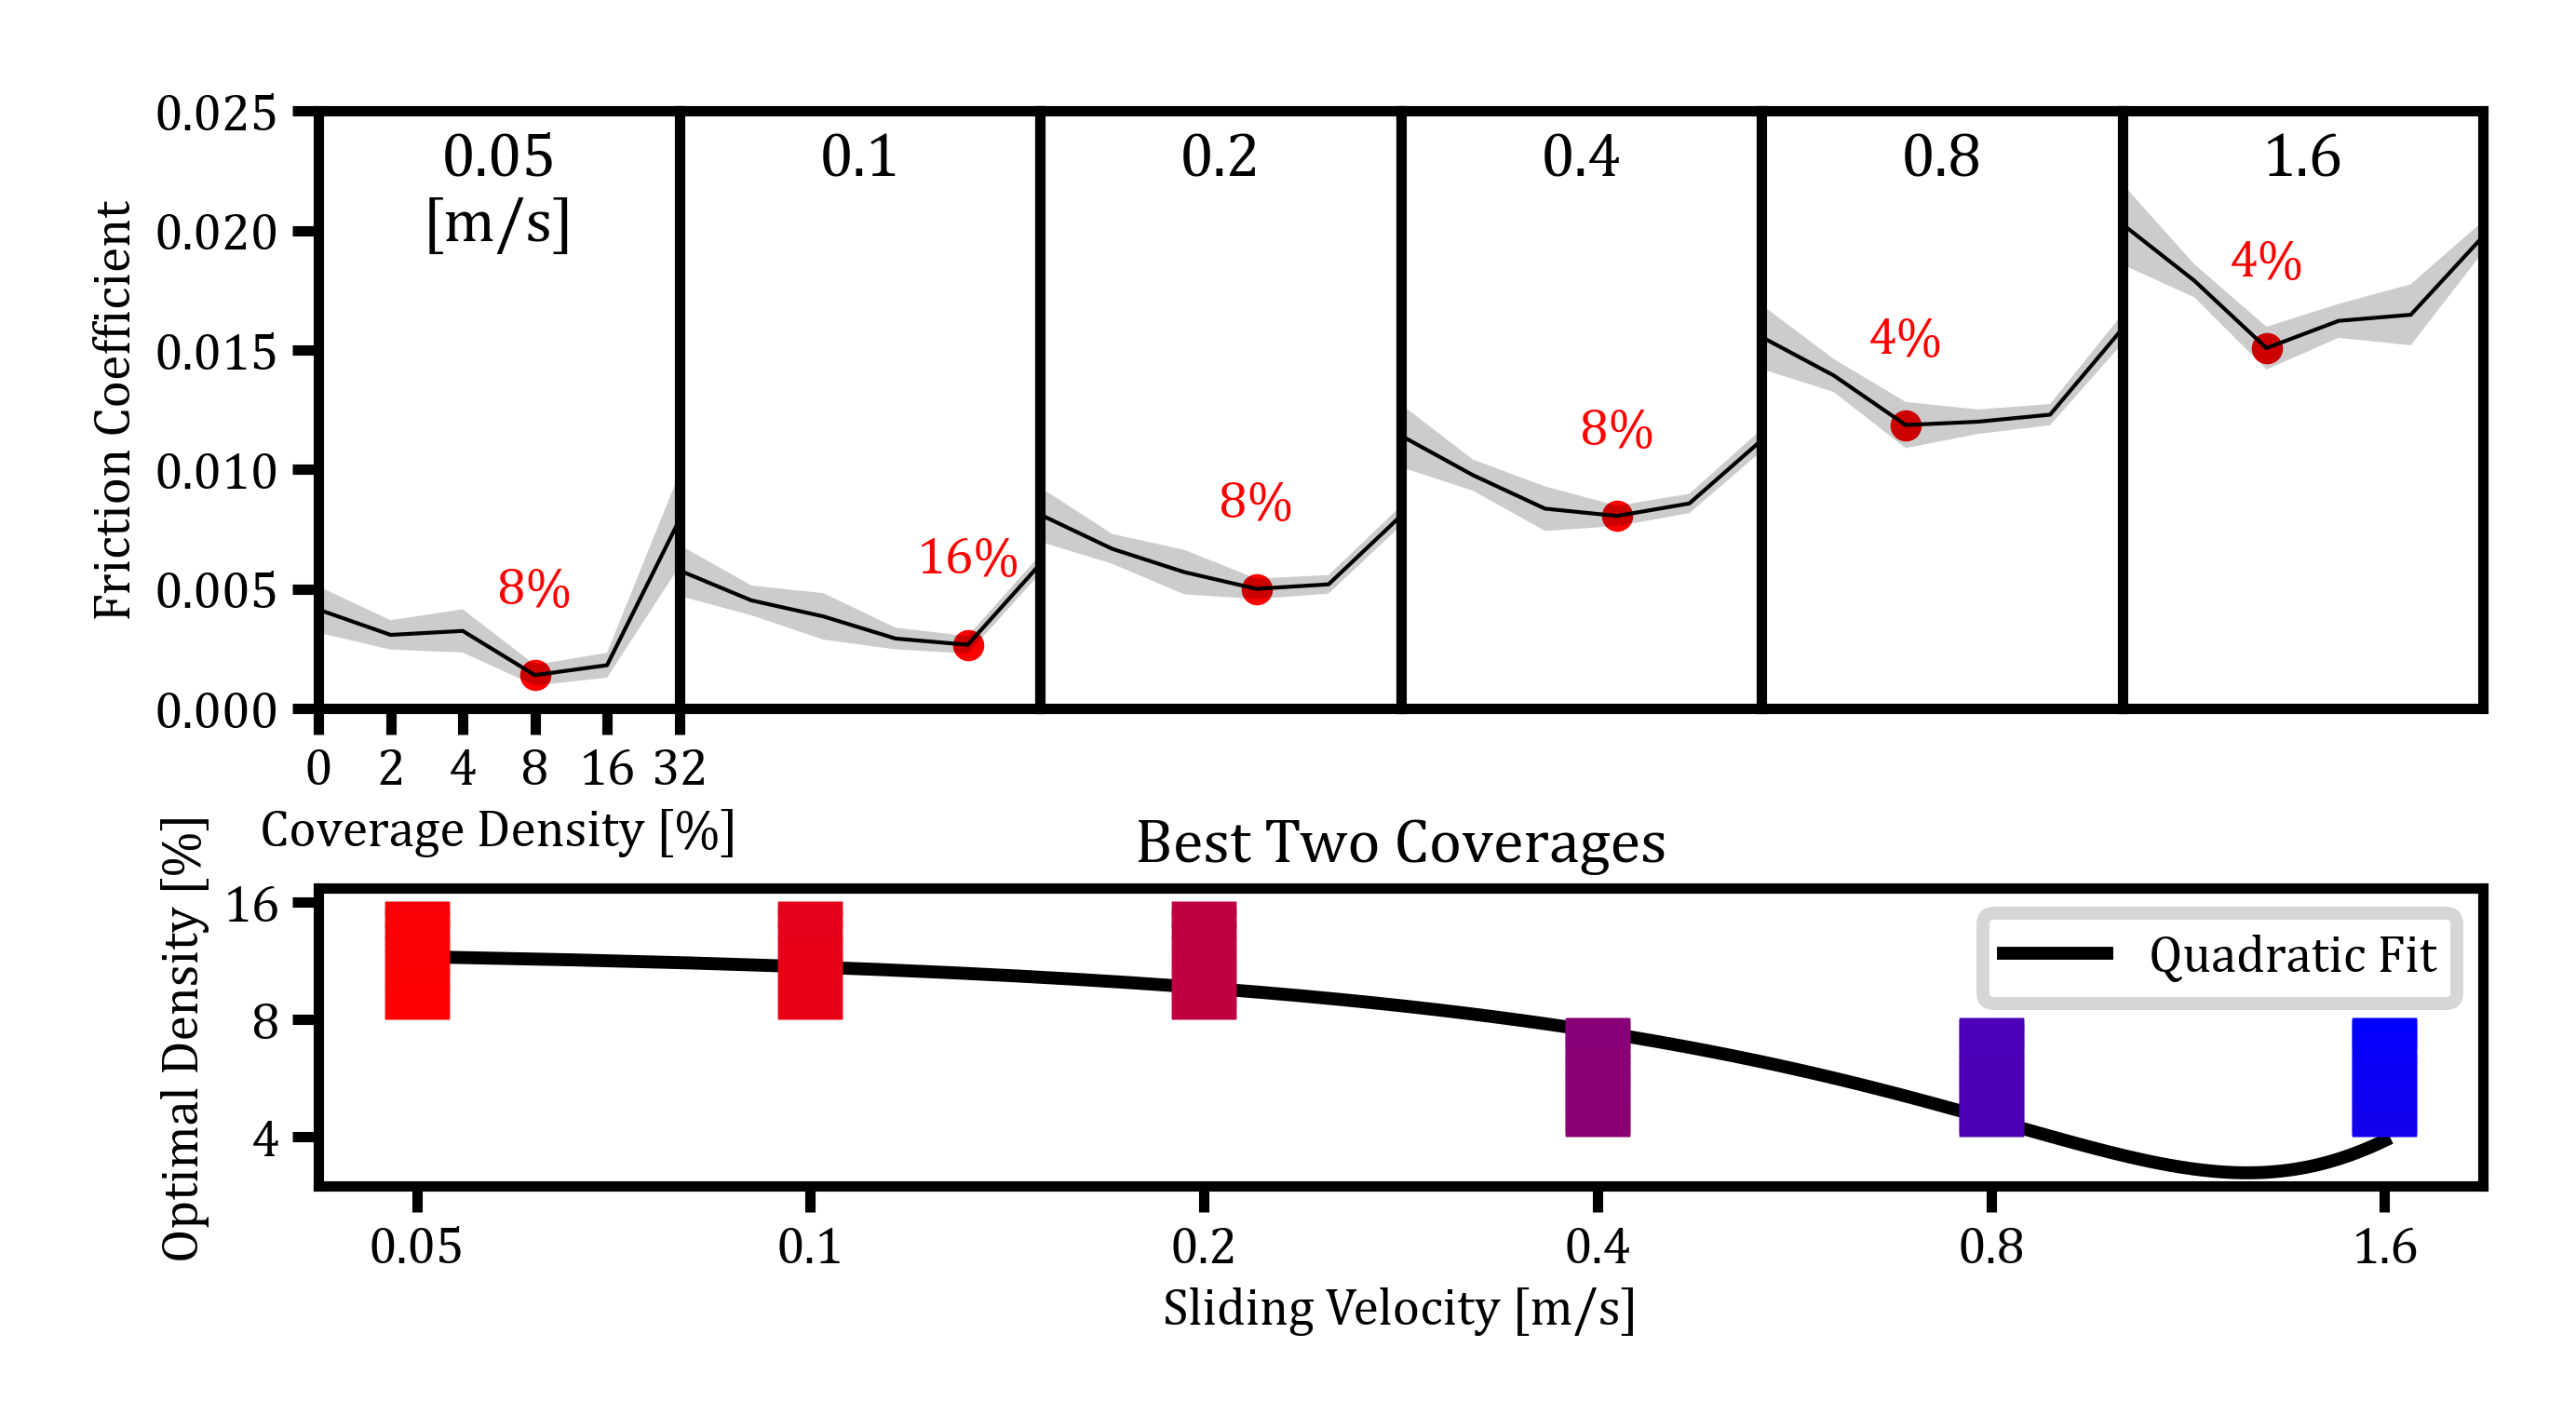

In [173]:
sigmas = 2
color = 'black'
outer_alpha = 0.2
inner_alpha = 0.2
linewidth = 0.3
min_color = 'red'
min_size = 2
fake_x = pd.Series(np.linspace(0,1,len(coverages)))
fig,axes = plt.subplot_mosaic(
    mosaic = [[velocities[0], velocities[1], velocities[2], velocities[3], velocities[4], velocities[5]],
              ["optimal_curve", "optimal_curve", "optimal_curve", "optimal_curve", "optimal_curve", "optimal_curve"]],
    height_ratios=[2,1]
)
fig.subplots_adjust(wspace=0, hspace=0.4)
axes[velocities[0]].set_ylim([0,0.025])
axes[velocities[0]].set_yticks(np.linspace(0,0.025,6))
axes[velocities[0]].set_xlim([0,1])
axes[velocities[0]].set_xticks(fake_x)
axes[velocities[0]].set_xticklabels(coverages)
axes[velocities[0]].tick_params(length=2,pad=1)
axes[velocities[0]].set_ylabel("Friction Coefficient",labelpad=1)
axes[velocities[0]].set_xlabel("Coverage Density [%]",labelpad=1)
[axes[id].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False) for id in [velocities[1], velocities[2], velocities[3], velocities[4], velocities[5]]]
[axes[id].sharex(axes[velocities[0]]) for id in [velocities[1], velocities[2], velocities[3], velocities[4], velocities[5]]]
[axes[id].sharey(axes[velocities[0]]) for id in [velocities[1], velocities[2], velocities[3], velocities[4], velocities[5]]]
[axes[id].set_title(str(id), y=1.0, pad=-5) for id in velocities]
axes[velocities[0]].set_title(str(velocities[0]) + "\n[m/s]", y=1.0, pad=-10)
for i in range(6):
    velocity = velocities[i]
    rpm = acceptable_rpms[i]
    mean = means[rpm]
    stdev = stdevs[rpm]
    ax = axes[velocity]
    ax.scatter(fake_x[min_rows[i]],min_mean[i],color=min_color,s=min_size)
    ax.annotate(str(min_coverages[i]) + "%",(fake_x[min_rows[i]],min_mean[i]+0.003),color=min_color,ha='center')
    ax.plot(fake_x,mean,linewidth=linewidth,color=color)
    # ax.plot(fake_x,mean+sigmas*stdev,color=color,linewidth=linewidth,alpha=outer_alpha)
    # ax.plot(fake_x,mean-sigmas*stdev,color=color,linewidth=linewidth,alpha=outer_alpha)
    ax.fill_between(fake_x,mean+sigmas*stdev,mean-sigmas*stdev,facecolor=color,alpha=inner_alpha)

def color_fader(c1, c2, mix=0):
    """Fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)"""
    c1 = np.array(mcolors.to_rgb(c1))
    c2 = np.array(mcolors.to_rgb(c2))
    return mcolors.to_hex((1-mix) * c1 + mix * c2)
c1 = 'red'
c2 = 'blue'

# axes["optimal_curve"].scatter(x_real,y_real,marker='.',s=10.0,lw=0,c='black',label="Observed Minima")
axes["optimal_curve"].plot(x_plot,y_plot,lw=1,c='black',label="Quadratic Fit") # \na = {:3.3f}\nb = {:3.3f}\nc = {:3.3f}\nR²={:3.3f}
for i in range(len(velocities)):
    rpm = acceptable_rpms[i]
    velocity = velocities[i]
    lower = lowest_two_coefs.at["lowest",rpm]
    upper = lowest_two_coefs.at["second_lowest",rpm]
    bottom = np.min([lowest_two_coverages.at["lowest",rpm],lowest_two_coverages.at["second_lowest",rpm]])
    top = np.max([lowest_two_coverages.at["lowest",rpm],lowest_two_coverages.at["second_lowest",rpm]])
    coverage_plot = np.linspace(bottom,top,101)
    coef_plot = np.linspace((lower-lowest_coef)/(highest_coef-lowest_coef),(upper-lowest_coef)/(highest_coef-lowest_coef),100)
    gradient = [color_fader(c1, c2, mix=i) for i in coef_plot]
    for j,color in enumerate(gradient):
        axes["optimal_curve"].vlines(velocity, ymin=coverage_plot[j], ymax=coverage_plot[j+1]+0.1, color=color, alpha=1, linewidth=5) # bottom+i*(bottom-top)/len(gradient)
axes["optimal_curve"].set_xlabel("Sliding Velocity [m/s]",labelpad=1)
axes["optimal_curve"].set_xscale("log")
axes["optimal_curve"].set_xticks(velocities)
axes["optimal_curve"].set_xticklabels(velocities)
axes["optimal_curve"].get_xaxis().set_tick_params(which='minor', size=0)
axes["optimal_curve"].get_xaxis().set_tick_params(which='minor', width=0) 
axes["optimal_curve"].get_xaxis().set_minor_formatter(NullFormatter())
axes["optimal_curve"].set_yscale("log")
axes["optimal_curve"].set_yticks([4,8,16])
axes["optimal_curve"].set_yticklabels([4,8,16])
axes["optimal_curve"].get_yaxis().set_tick_params(which='minor', size=0)
axes["optimal_curve"].get_yaxis().set_tick_params(which='minor', width=0) 
axes["optimal_curve"].get_yaxis().set_minor_formatter(NullFormatter())
axes["optimal_curve"].set_ylabel("Optimal Density [%]",labelpad=1)
axes["optimal_curve"].set_title("Best Two Coverages",pad=2)
axes["optimal_curve"].legend()
axes["optimal_curve"].tick_params(length=2,pad=1)
fig.set_size_inches(3,1.5)

In [274]:
# sigmas = 2
# color = 'black'
# outer_alpha = 0.2
# inner_alpha = 0.1
# linewidth = 0.2
# min_color = 'red'
# min_size = 4
# fig,axes = plt.subplots()
# axes.set_xscale("log")
# axes.set_ylim([0,0.025])
# axes.set_yticks(np.linspace(0,0.025,6))
# axes.set_xlim([velocities[0],velocities[-1]])
# axes.set_xticks(velocities)
# axes.set_xticklabels(velocities)
# axes.set_xlabel("Relative Velocity [m/s]")
# axes.set_ylabel("Friction Coefficient")
# axes.set_title("COF vs. velocity")
# colors = mpl.colormaps['tab10'].colors 
# for i in range(6):
#     coverage = coverages[i]
#     mean = means.iloc[i]
#     stdev = stdevs.iloc[i]
#     axes.plot(velocities,mean,linewidth=linewidth,color=colors[i],label="{}%".format(coverage))
#     axes.plot(velocities,mean+sigmas*stdev,color=colors[i],linewidth=linewidth,alpha=outer_alpha)
#     axes.plot(velocities,mean-sigmas*stdev,color=colors[i],linewidth=linewidth,alpha=outer_alpha)
#     axes.fill_between(velocities,mean+sigmas*stdev,mean-sigmas*stdev,color=colors[i],alpha=inner_alpha)
# axes.legend(loc='upper left')
# fig.set_size_inches(2,2)

In [275]:
# mpl.colormaps['tab10'].colors

In [276]:
# def fun(c,io):
#     x,y,z = io
#     return (c[0]*x[:,None]**3             +
#             c[1]*x[:,None]**2             +
#             c[2]*x[:,None]                +
#             c[3]*y[None,:]**3             +
#             c[4]*y[None,:]**2             +
#             c[5]*y[None,:]                +
#             c[6]*x[:,None]**2 * y[None,:] +
#             c[7]*x[:,None] * y[None,:]    +
#             c[8]*x[:,None] * y[None,:]**2 +
#             c[9])

# def eval(c,io):
#     x,y,z = io
#     z_fit = fun(c,io)
#     return np.ravel(z_fit-z)

# x_real = np.array(velocities)
# y_real = np.array(coverages)
# z_real = np.array(means)
# c_init = np.ones(10)
# result = sp.optimize.least_squares(eval,c_init,args=((x_real,y_real,z_real),))
# c_final = result.x
# x_plot = np.linspace(velocities[0],velocities[-1],100)
# y_plot = np.linspace(coverages[0],coverages[-1],100)
# z_plot = fun(c_final,(x_plot,y_plot,0))
# z_fit = fun(c_final,(x_real,y_real,0))